In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian
from quspin.tools.evolution import ED_state_vs_time, expm_multiply_parallel
from quspin.tools.Floquet import Floquet_t_vec, Floquet
from tqdm import tqdm

import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.fallback'] = 'stix'
plt.rcParams['font.family'] ='Times New Roman'
plt.style.use('seaborn-v0_8-deep')
prop_cycle = plt.rcParams['axes.prop_cycle']
dcolors = prop_cycle.by_key()['color']

# Model

The O'brian-Fendley model is much like the normal Majorana-Hubbard chain but with a slightly modified interaction term:

\begin{align*}
H_{OF} =& -it\sum_j \gamma_j \gamma_{j+1} -g \sum_j \gamma_{j-2}\gamma_{j-1}\gamma_{j+1}\gamma_{j+2}\\
=& t \sum_j \left(\sigma_j^x +\sigma_j^z \sigma_{j+1}^z\right)
+g \sum_j\left(\sigma_j^x \sigma_{j+1}^x \sigma_{j+2}^z + \sigma_j^z \sigma_{j+1}^z \sigma_{j+2}^z\right)
\end{align*}

In [2]:
def drive(t, omega):
    return np.cos(omega*t)

def Hof_dynamic(omega, g, basis):
    """
    Hopping strength is cos(omega t) (time t is fed later to the Hamiltonian function)
    g is the coupling strength
    basis is quspin spinless_fermion_basis_1d
    """
    
    L = basis.N
    
    x_lst = [[-2, i] for i in range(L)]
    
    zz_lst = [[-2, i, i+1] for i in range(L-1)]
    
    xzz_lst = [[g, i, i+1, i+2] for i in range(L-2)]
    zzx_lst = [[g, i, i+1, i+2] for i in range(L-2)]

    zz_lst += [[-2, L-1, 0]]
    
    xzz_lst += [[g, L-2, L-1, 0],
                [g, L-1, 0, 1]]
    
    zzx_lst += [[g, L-2, L-1, 0],
                [g, L-1, 0, 1]]
    static = [['zxx', xzz_lst],
              ['xxz', zzx_lst]]
    dynamic = [['z', x_lst, drive, [omega]],
               ['xx', zz_lst, drive, [omega]]]
    
    H = hamiltonian(static, dynamic, basis=basis, check_symm=False, check_herm=False)
    return H

# Time evolution (with dynamical Hamiltonian)

I'm going to start with the $t=0$ ground state and evolve for a few periods using a built-in function from QuSpin that handles dynamic Hamiltonians by solving the Schrodinger equation. I don't know how efficient it is, so beware for large systems!

In [3]:
L = 12
basis = spin_basis_1d(L, pauli=1) # pauli matrix, not spin 1/2 (matches iTensor "S=1/2")
g = 1.1
#omega = 1/np.sqrt(1+g**2)
omega = 100
H = Hof_dynamic(omega, g, basis)
e, v = H.eigsh(time=0, k=4, which='SA') # diagonalizing at time t=0
print(e[:4])
print()
print(np.sort(e[:4]))
v0 = v[:,np.argmin(e)]
T = 2*np.pi/omega

[-24.09959038 -24.11518804 -24.1075064  -22.33317603]

[-24.11518804 -24.1075064  -24.09959038 -22.33317603]


In [15]:
periods = 50
steps = 10*periods + 1 # 10 steps per period
autoc = np.zeros(steps, dtype=np.complex128)
sz0 = hamiltonian([['x', [[1.0,0]]]], [], basis=basis, check_symm=False, check_herm=False)
zv0 = sz0.dot(v0)
zv0 *= 1./np.linalg.norm(zv0)


times = np.linspace(0, periods*T, steps)
energies = np.zeros(steps)
olaps = np.zeros(steps, dtype=np.complex128)
vs = H.evolve(v0, 0, times, iterate=False)
zvs = H.evolve(zv0, 0, times, iterate=False)

In [16]:
for i, t in enumerate(times):
    vi = vs[:,i]
    zvi = zvs[:,i]
    energies[i] = H.expt_value(vi, time=t).real
    olaps[i] = np.vdot(vi, v0)
    autoc[i] = sz0.matrix_ele(zvi, vi)

In [17]:
data = pd.read_csv(f'L{L}_g{g}_omega{omega}_N{periods}.csv')
td = data["time"]
od = data["overlap"]
acd = data["re_autoc"] + 1j*data["im_autoc"]

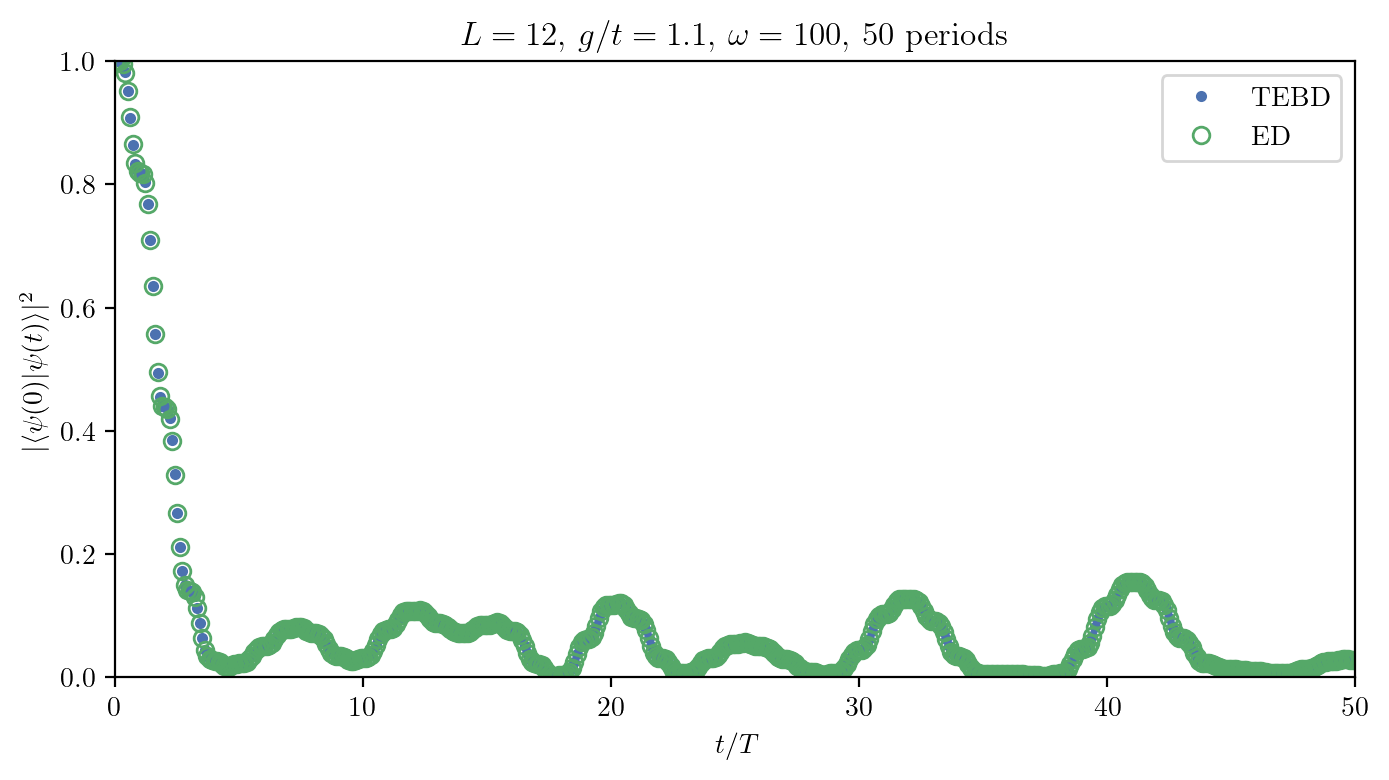

In [18]:
plt.figure(figsize=(8,4), dpi=200)
plt.plot(times/T, od, '.', label="TEBD")
plt.plot(times/T, np.abs(olaps)**2, 'o', markerfacecolor='none', label="ED",)
plt.ylim(0,1)

plt.xlim(0, times[-1]/T)
plt.xlabel(r'$t/T$')
plt.ylabel(r'$|\langle \psi(0)|\psi(t)\rangle|^2$')
plt.title(f'$L={L}$, $g/t={g}$, $\omega={omega}$, {periods} periods')
plt.legend()

Text(0.5, 0, '$t/T$')

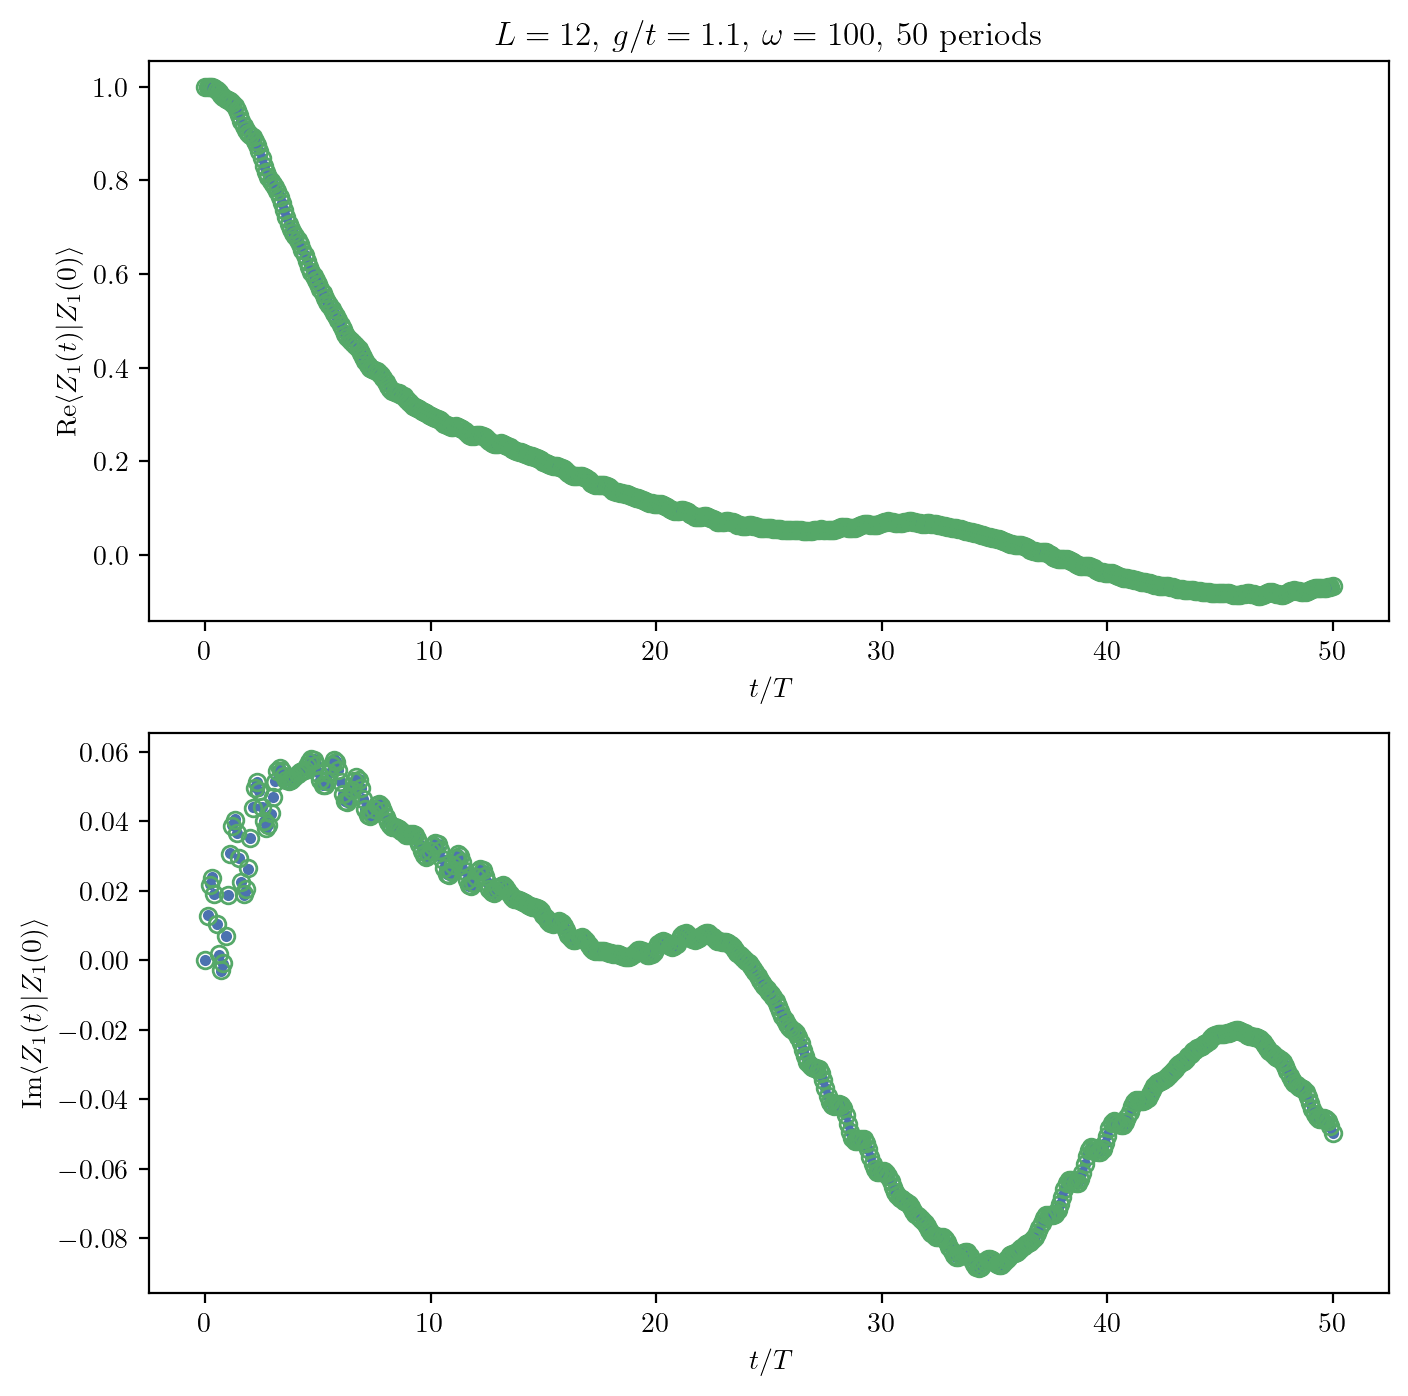

In [19]:
plt.figure(figsize=(8,8), dpi=200)

plt.subplot(2,1,1)
plt.plot(times/T, np.real(acd), '.', label='TEBD')
plt.plot(times/T, np.real(autoc), 'o', markerfacecolor='none', label='ED')
plt.title(f'$L={L}$, $g/t={g}$, $\omega={omega}$, {periods} periods')
plt.ylabel(r'Re$\langle Z_1(t)|Z_1(0)\rangle$')
plt.xlabel(r'$t/T$')

#plt.ylim(0, 1)
#plt.xlim(0, times[-1]/T)
plt.subplot(2,1,2)
plt.plot(times/T, np.imag(acd), '.', label='TEBD')
plt.plot(times/T, np.imag(autoc), 'o', markerfacecolor='none', label='ED')
plt.ylabel(r'Im$\langle Z_1(t)|Z_1(0)\rangle$')

plt.xlabel(r'$t/T$')


#plt.savefig(f'L{L}_g{g}_omega{omega}.pdf', bbox_inches='tight')

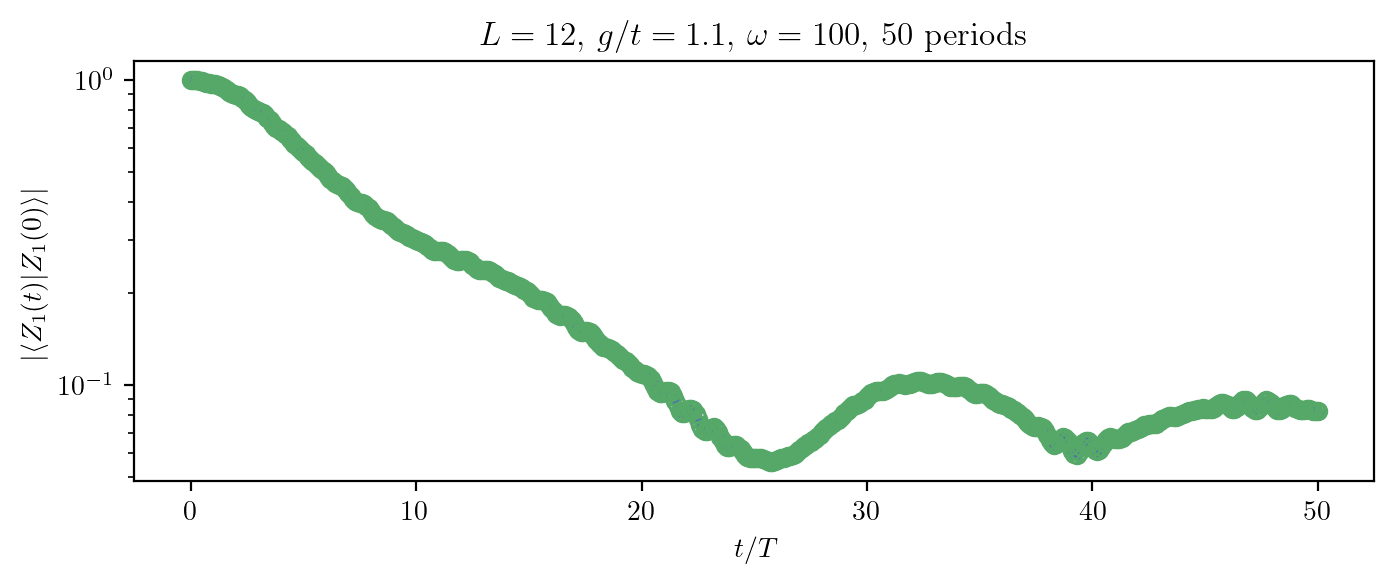

In [28]:
plt.figure(figsize=(8,6), dpi=200)

plt.subplot(2,1,1)
plt.plot(times/T, np.abs(acd), '.', label='TEBD')
plt.plot(times/T, np.abs(autoc), 'o', markerfacecolor='none', label='ED')
plt.title(f'$L={L}$, $g/t={g}$, $\omega={omega}$, {periods} periods')
plt.ylabel(r'$|\langle Z_1(t)|Z_1(0)\rangle |$')
plt.xlabel(r'$t/T$')
plt.yscale("log")

#plt.savefig(f'L{L}_g{g}_omega{omega}.pdf', bbox_inches='tight')

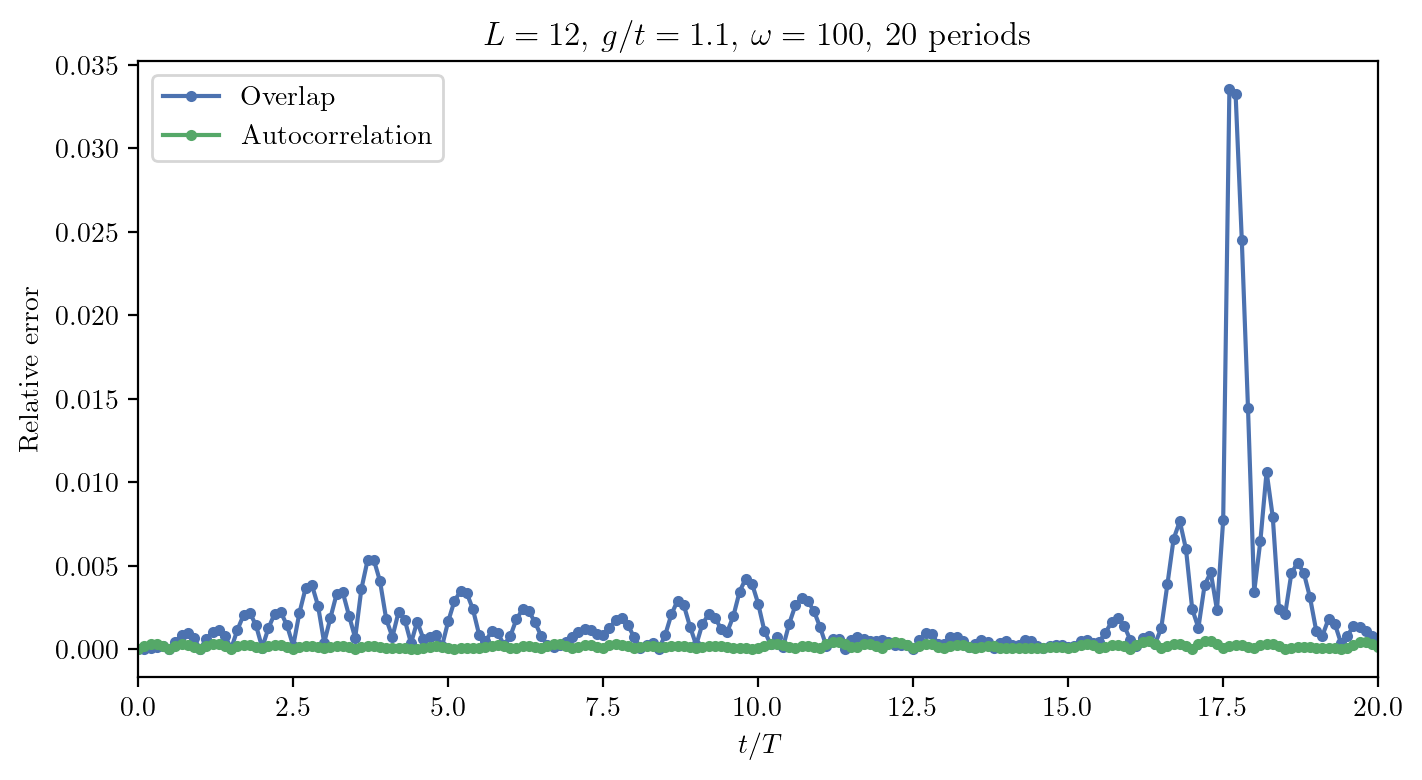

In [9]:
plt.figure(figsize=(8,4), dpi=200)
plt.plot(times/T, np.abs(np.abs(olaps)**2-od)/(np.abs(olaps)**2), '.-', label="Overlap")
plt.plot(times/T, np.abs(acd-autoc)/np.abs(acd), '.-', label="Autocorrelation")


plt.xlim(0, times[-1]/T)
plt.xlabel(r'$t/T$')
plt.ylabel(r'Relative error')
plt.title(f'$L={L}$, $g/t={g}$, $\omega={omega}$, {periods} periods')
plt.legend()